In [1]:
#! /usr/bin/env python
import numpy as np
import numpy.ma as ma
from scipy.interpolate import griddata, interp1d
import netCDF4 as nc
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean as cm
from matplotlib.colors import LinearSegmentedColormap
import os
import gsw
os.environ['PROJ_LIB'] = r'/home/eolson/anaconda3/envs/py38/share/proj'
from mpl_toolkits.basemap import Basemap, shiftgrid
import matplotlib as mpl
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')


%matplotlib inline

In [2]:
#load station locations
infil = np.loadtxt('Map_v1.txt') #input file

In [3]:
#-------------COLORMAP GENERATION ROUTINE------------------ you don't need to understand this part
def LevelColormap(levels, cmap=None):
    """Make a colormap based on an increasing sequence of levels"""
    
    # Start with an existing colormap
    if cmap == None:
        cmap = plt.get_cmap()

    # Spread the colours maximally
    nlev = len(levels)
    S = np.arange(nlev, dtype='float')/(nlev-1)
    A = cmap(S)

    # Normalize the levels to interval [0,1]
    levels = np.array(levels, dtype='float')
    L = (levels-levels[0])/(levels[-1]-levels[0])

    # Make the colour dictionary
    R = [(L[i], A[i,0], A[i,0]) for i in range(nlev)]
    G = [(L[i], A[i,1], A[i,1]) for i in range(nlev)]
    B = [(L[i], A[i,2], A[i,2]) for i in range(nlev)]
    cdict = dict(red=tuple(R),green=tuple(G),blue=tuple(B))

    # Use 
    return LinearSegmentedColormap('%s_levels' % cmap.name, cdict, 256)
#---------------------------------------------------------------

In [4]:
liveocean_fname='salt_elise.nc'
f=nc.Dataset(liveocean_fname)
f.variables['salt']

<class 'netCDF4._netCDF4.Variable'>
float32 salt(ocean_time, s_rho, eta_rho, xi_rho)
    long_name: salinity
    time: ocean_time
    grid: grid
    location: face
    coordinates: lon_rho lat_rho s_rho ocean_time
    field: salinity, scalar, series
    _FillValue: 1e+37
unlimited dimensions: ocean_time
current shape = (1, 1, 1302, 663)
filling on

In [5]:
f.close()

In [6]:
liveocean_fname='salt_elise.nc'
## check units!!
f=nc.Dataset(liveocean_fname)
lonLO = f.variables["lon_rho"][:,:] #variable taken from the file
latLO = f.variables["lat_rho"][:,:]
salLO = gsw.SA_from_SP(f.variables["salt"][0,0,:,:],0,lonLO,latLO)
salLO_0 = f.variables["salt"][0,0,:,:]
f.close()

In [7]:
# SSC salinity and lat/lon
# convert units??
sal1_fname = '/results/SalishSea/nowcast-green.201812/01jun17/SalishSea_1h_20170601_20170601_grid_T.nc' #too be changed with the one Debby is going to send you
f = nc.Dataset(sal1_fname,'r')
lonSS = f.variables["nav_lon"][:,1:] #variable taken from the file
latSS = f.variables["nav_lat"][:,1:]
salSS = f.variables["vosaline"][0,0,:,1:]
f.close()

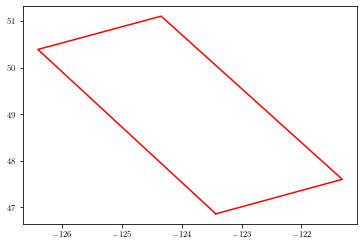

In [8]:
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc') as mesh:
    l=mesh.variables['nav_lat']
    boxlat=[l[0,0],l[0,-1],l[-1,-1],l[-1,0],l[0,0]]
    l=mesh.variables["nav_lon"]
    boxlon=[l[0,0],l[0,-1],l[-1,-1],l[-1,0],l[0,0]]
plt.plot(boxlon,boxlat,'r-')

In [9]:
cm1=cm.cm.haline

In [10]:
def getblob(file):
    res=10
    ol=5
    blob1=np.loadtxt(file,delimiter=',')
    blob1=np.concatenate((blob1[-ol:,:],blob1,blob1[:ol]),0)
    x=blob1[:,0]
    y=blob1[:,1]
    t = np.arange(len(blob1))
    ti = np.linspace(t[ol], t[-1*ol], res * (t.size-2*ol+1))
    xi = interp1d(t, x, kind='cubic')(ti)
    yi = interp1d(t, y, kind='cubic')(ti)
    return xi,yi,x,y

130 22
130 22
120 21
200 29


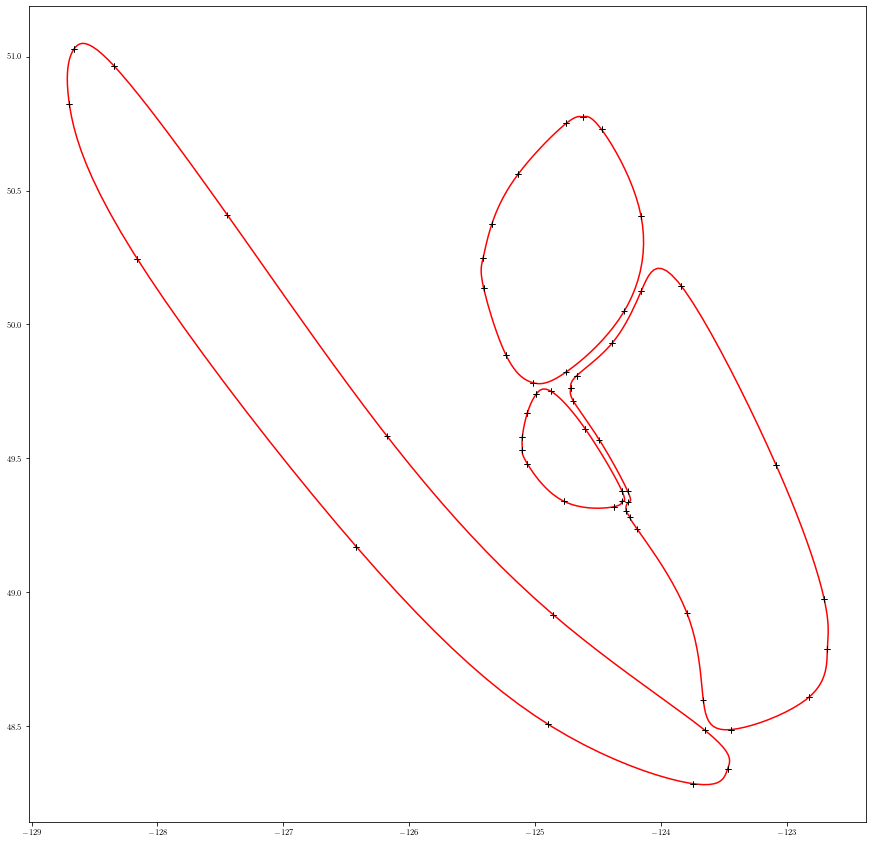

In [11]:
fig,ax=plt.subplots(1,1,figsize=(15,15))
for fn in ('blob1.csv','blob2.csv','blob3.csv','blob4.csv'):
    xi,yi,x0,y0=getblob(fn)
    ax.plot(xi,yi,'r-')
    ax.plot(x0,y0,'k+')
    print(len(xi),len(x0))

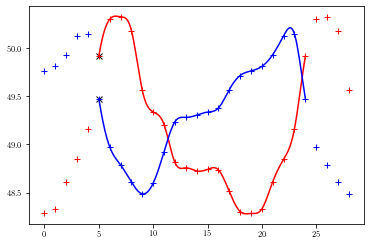

In [12]:
res=10
ol=5
blob1=np.loadtxt('blob4.csv',delimiter=',')
plt.plot(5,blob1[0,0]+173,'kx')
plt.plot(5,blob1[0,1],'kx')
blob1=np.concatenate((blob1[-ol:,:],blob1,blob1[:ol]),0)
x=blob1[:,0]
y=blob1[:,1]
t = np.arange(len(blob1))
ti = np.linspace(t[ol], t[-1*ol], res * (t.size-2*ol+1))
xi = interp1d(t, x, kind='cubic')(ti)
yi = interp1d(t, y, kind='cubic')(ti)
plt.plot(t,x+173,'r+')
plt.plot(ti,xi+173,'r-')
plt.plot(t,y,'b+')
plt.plot(ti,yi,'b-')

In [13]:
a,b,c,d=getblob('blob1.csv')

In [14]:
len(a),len(b),len(c),len(d)

(130, 130, 22, 22)

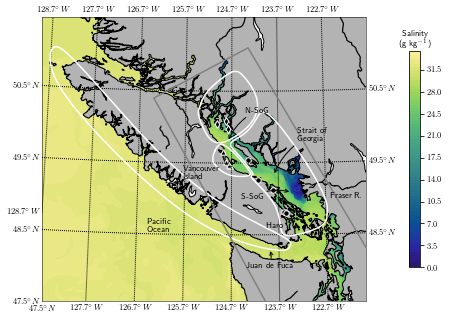

In [35]:
fig=plt.figure(figsize=(7.5,5))
slat = infil[:,6]
slon = infil[:,7]
ln = infil[:,2]

#model site
modlat = 49.125
modlong = - 123.558

#some masking
mskJ = (ln == 5) #black dots
mskH = (ln == 4) #blue dots
mskS = (ln == 2) #green dots
mskC = (ln == 1.5) #nothing
mskN = (ln == 1) #orange dots

# Define boundaries
latStart = 47.5 #47.5
latEnd = 51.5
lonStart = -128.6
lonEnd = -121.7

# Define map projection
axm=fig.add_axes([.1,.1,.6,.8])
m = Basemap(ax=axm,llcrnrlon = lonStart, llcrnrlat = latStart, urcrnrlon = lonEnd, 
  urcrnrlat = latEnd, resolution = 'f', projection = 'cass', lon_0=-124.5, 
  lat_0=48.75) #cassini projection (not sure)
m.drawmapboundary(fill_color='white', linewidth=0.5) #boundaries colour

cbax=fig.add_axes([.78,.2,.02,.6])

# Draw bathymetry
#lon, lat = np.meshgrid(lon, lat) # recast lat and lon as meshgrids
xLO, yLO = m(lonLO, latLO) # and convert to x, y coordinates in map projection
xSS, ySS = m(lonSS, latSS) # and convert to x, y coordinates in map projection
xbox,ybox = m(boxlon,boxlat)
levels = np.arange(0,35,.5) # change the different classes here
m0=m.contourf(xLO, yLO, salLO, levels, cmap = LevelColormap(levels, cmap = cm1))
m1=m.contourf(xSS, ySS, salSS, levels, cmap = LevelColormap(levels, cmap = cm1))
mpl.rcParams['contour.negative_linestyle'] = 'solid' # drawing line of regions
cb=fig.colorbar(m0,cax=cbax)
cbax.set_title('Salinity\n(g kg$^{-1}$)')

# define some colours (if you need new colours, see website https://flatuicolors.com/ - numbers should between 1 and 0, so divide by 256)
# colours by default are in yellow '', see python documentation
brgree=(0., 1., 0.)
pureblue=(0., 0., 1.)
harblue=(0.9, 0., 0.9)
orange=(0.9, 0.6, 0.)

# Draw coasts, rivers, continents
m.fillcontinents(color=(0.7, 0.7, 0.7), lake_color='white')
m.drawcoastlines()
m.drawrivers(linewidth=1.2) # change the line depth of rivers

# draw parallels and meridians.
m.drawparallels(np.arange(47.5,51.5,1.), labels=[True,True,True,True],size=8)
m.drawmeridians(np.arange(-128.7,-121.7,1.), labels=[True,True,True,True],size=8)

# plot station locations
m.scatter(slon[mskH], slat[mskH], s=30, color= 'k', marker = 'o', edgecolor = 'white', 
          linewidth = 1, latlon=True, zorder=2)
m.scatter(slon[mskS], slat[mskS], s=30, color= 'k', marker = '^', edgecolor = 'white', 
          linewidth = 1, latlon=True, zorder=2)
m.scatter(slon[mskN], slat[mskN], s=30, color= 'k', marker = 'd', edgecolor = 'white', 
          linewidth = 1, latlon=True, zorder=2)
xi,yi,px,py=getblob('blob1.csv')
m.plot(xi,yi, 'w-', latlon=True, zorder=2)
#m.plot(px,py, 'r*', latlon=True, zorder=2)
xi,yi,px,py=getblob('blob2.csv')
m.plot(xi,yi, 'w-', latlon=True, zorder=2)
#m.plot(px,py, 'r*', latlon=True, zorder=2)
xi,yi,px,py=getblob('blob3.csv')
m.plot(xi,yi, 'w-', latlon=True, zorder=2)
#m.plot(px,py, 'r*', latlon=True, zorder=2)
xi,yi,px,py=getblob('blob4.csv')
m.plot(xi,yi, 'w-', latlon=True, zorder=2)
#m.plot(px,py, 'r*', latlon=True, zorder=2)
#m.scatter(modlong, modlat, color='k', s=30, latlon=True)
#m.scatter(modlong, modlat, color='w', s=20, latlon=True)

m.plot(xbox,ybox,'-',color='gray',zorder=2)

# Normal annotations (Name, location, useless) add whatever you want, \n is space
axm.annotate('Vancouver\nIsland', xy=m(-125.74,49.28), xycoords='data',size=8)
axm.annotate('Fraser R.', xy=m(-122.60,49.), xycoords='data',size=8)
axm.annotate('Pacific\nOcean', xy=m(-126.465,48.53), xycoords='data',size=8)

# Annotations with lines, add here if you want to add a label with an arrow (Name, location of label, useless, location of end arrow, useless, kind of arrow)
axm.annotate('N-SoG', xy=m(-124.78, 49.8), xycoords='data', xytext=m(-124.4, 50.2), 
             textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'),size=8)
axm.annotate('S-SoG', xy=m(-123.43, 49.09), xycoords='data', xytext=m(-124.5, 49), 
             textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2'),size=8)
axm.annotate('Haro', xy=m(-123.09, 48.67), xycoords='data', xytext=m(-123.98, 48.60), 
             textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3'),size=8)
axm.annotate('Juan de Fuca', xy=m(-123.9,48.3), xycoords='data', xytext=m(-124.40, 48.04), 
             textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'),size=8)
axm.annotate('Strait of\nGeorgia', xy=m(-123.8,49.33), xycoords='data', xytext=m(-123.30, 49.8), 
             textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'),size=8)

plt.show()
fig.savefig('StudyAreaMap.png',dpi=400,bbox_inches='tight')

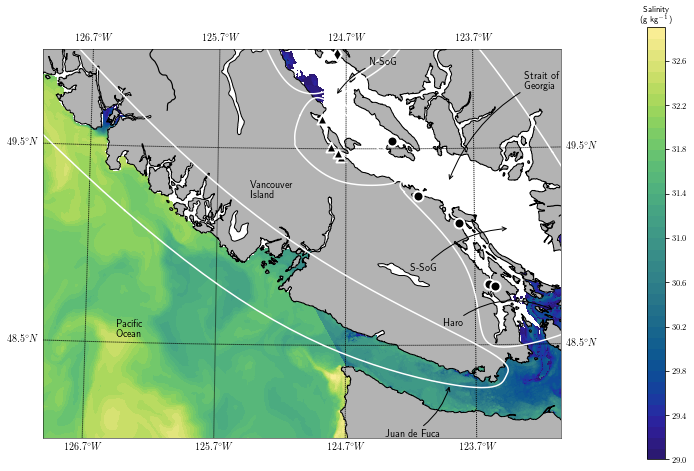

In [16]:
fig=plt.figure(figsize=(12,10))
slat = infil[:,6]
slon = infil[:,7]
ln = infil[:,2]

#model site
modlat = 49.125
modlong = - 123.558

#some masking
mskJ = (ln == 5) #black dots
mskH = (ln == 4) #blue dots
mskS = (ln == 2) #green dots
mskC = (ln == 1.5) #nothing
mskN = (ln == 1) #orange dots

# Define boundaries
latStart = 48 #47.5
latEnd = 50
lonStart = -127
lonEnd = -123

# Define map projection
axm=fig.add_axes([.1,.1,.6,.8])
m = Basemap(ax=axm,llcrnrlon = lonStart, llcrnrlat = latStart, urcrnrlon = lonEnd, 
  urcrnrlat = latEnd, resolution = 'f', projection = 'cass', lon_0=-124.5, 
  lat_0=48.75) #cassini projection (not sure)
m.drawmapboundary(fill_color='white', linewidth=0.5) #boundaries colour

cbax=fig.add_axes([.8,.2,.02,.6])

# Draw bathymetry
#lon, lat = np.meshgrid(lon, lat) # recast lat and lon as meshgrids
xLO, yLO = m(lonLO, latLO) # and convert to x, y coordinates in map projection
xSS, ySS = m(lonSS, latSS) # and convert to x, y coordinates in map projection
levels = np.arange(29,33,.1) # change the different classes here
m0=m.contourf(xLO, yLO, salLO, levels, cmap = LevelColormap(levels, cmap = cm1))
m1=m.contourf(xSS, ySS, salSS, levels, cmap = LevelColormap(levels, cmap = cm1))
#levels = [-150] # define the black line to determine the regions
mpl.rcParams['contour.negative_linestyle'] = 'solid' # drawing line of regions
#c = m.contour(x, y, bathy, levels, colors = 'k', linewidth=0.1) # drawing line of regions #black contour lines
#plt.clabel(c, inline=1, fmt='%d', fontsize=7) # label of the altitude of the line of regions #black contour lines
# - 150 shows the two shallow parts at the north end of the southern gulf islands
# - 200 shows the deep trench in Haro (as does - 150)
# - 120 highlights the Victoria sill nicely
cb=fig.colorbar(m0,cax=cbax)
cbax.set_title('Salinity\n(g kg$^{-1}$)')

# define some colours (if you need new colours, see website https://flatuicolors.com/ - numbers should between 1 and 0, so divide by 256)
# colours by default are in yellow '', see python documentation
brgree=(0., 1., 0.)
pureblue=(0., 0., 1.)
#harblue=(0.2, 0., 0.7)
#lpurple=(0.9, 0., 0.9)
harblue=(0.9, 0., 0.9)
orange=(0.9, 0.6, 0.)

# Draw coasts, rivers, continents
m.fillcontinents(color=(0.7, 0.7, 0.7), lake_color='white')
m.drawcoastlines()
#m.drawcountries() # if you want the countries, uncomment here
#m.drawrivers() # same for rivers
m.drawrivers(linewidth=1.2) # change the line depth of rivers

# draw parallels and meridians.
m.drawparallels(np.arange(47.5,51.5,1.), labels=[True,True,True,True])
m.drawmeridians(np.arange(-128.7,-121.7,1.), labels=[True,True,True,True])

# plot station locations
# m.scatter(slon, slat, color='w', s=50, latlon=True, zorder=2)
#m.scatter(slon, slat, color='r', latlon=True)

# m.scatter(slon[mskJ], slat[mskJ], color='k', latlon=True, zorder=2) # only plot if ln = 5
# m.scatter(slon[mskH], slat[mskH], s=30, color= '#CB2CD8', latlon=True, zorder=2)
# m.scatter(slon[mskS], slat[mskS], s=30, color= '#B86D26', latlon=True, zorder=2)
# m.scatter(slon[mskN], slat[mskN], s=30, color= '#459C4A', latlon=True, zorder=2)
m.scatter(slon[mskH], slat[mskH], s=100, color= 'k', marker = 'o', edgecolor = 'white', linewidth = 2, latlon=True, zorder=2)
m.scatter(slon[mskS], slat[mskS], s=100, color= 'k', marker = '^', edgecolor = 'white', linewidth = 2, latlon=True, zorder=2)
m.scatter(slon[mskN], slat[mskN], s=100, color= 'k', marker = 'd', edgecolor = 'white', linewidth = 2, latlon=True, zorder=2)
xi,yi,px,py=getblob('blob1.csv')
m.plot(xi,yi, 'w-', latlon=True, zorder=2)
#m.plot(px,py, 'r*', latlon=True, zorder=2)
xi,yi,px,py=getblob('blob2.csv')
m.plot(xi,yi, 'w-', latlon=True, zorder=2)
#m.plot(px,py, 'r*', latlon=True, zorder=2)
xi,yi,px,py=getblob('blob3.csv')
m.plot(xi,yi, 'w-', latlon=True, zorder=2)
#m.plot(px,py, 'r*', latlon=True, zorder=2)
xi,yi,px,py=getblob('blob4.csv')
m.plot(xi,yi, 'w-', latlon=True, zorder=2)
#m.plot(px,py, 'r*', latlon=True, zorder=2)
#m.scatter(modlong, modlat, color='k', s=30, latlon=True)
#m.scatter(modlong, modlat, color='w', s=20, latlon=True)


# Normal annotations (Name, location, useless) add whatever you want, \n is space
axm.annotate('Vancouver\nIsland', xy=m(-125.45,49.25), xycoords='data')
#plt.annotate('British\nColumbia', xy=m(-122.70,50.20), xycoords='data')
axm.annotate('Fraser R.', xy=m(-122.90,49.105), xycoords='data')
# plt.annotate('River', xy=m(-122.49,49.04), xycoords='data')
#plt.annotate('Juan\nde\n Fuca', xy=m(-124.40,48.06), xycoords='data')
# plt.annotate('Skagit R.', xy=m(-122.25,48.41), xycoords='data')
axm.annotate('Pacific\nOcean', xy=m(-126.465,48.53), xycoords='data')

# Annotations with lines, add here if you want to add a label with an arrow (Name, location of label, useless, location of end arrow, useless, kind of arrow)
axm.annotate('N-SoG', xy=m(-124.78, 49.77), xycoords='data', xytext=m(-124.52, 49.93), textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
axm.annotate('S-SoG', xy=m(-123.43, 49.09), xycoords='data', xytext=m(-124.20, 48.88), textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2'))
axm.annotate('Haro', xy=m(-123.09, 48.67), xycoords='data', xytext=m(-123.95, 48.60), textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3'))
axm.annotate('Juan de Fuca', xy=m(-123.9,48.3), xycoords='data', xytext=m(-124.40, 48.04), textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
#plt.annotate('Fraser River', xy=m(-123.0,49.26), xycoords='data', xytext=m(-122.40, 49.10), textcoords='data', arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0.0'))
# plt.annotate('Puget\nSound', xy=m(-122.45,47.84), xycoords='data', xytext=m(-122.13, 47.9), textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
axm.annotate('Strait of\nGeorgia', xy=m(-123.9,49.33), xycoords='data', xytext=m(-123.30, 49.8), textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
             
# show and save plot
# plt.savefig('StudyAreaMap.pdf')
# plt.savefig('StudyAreaMap.jpeg')

plt.show()
#fig.savefig('StudyAreaMap.png',dpi=150,bbox_inches='tight')

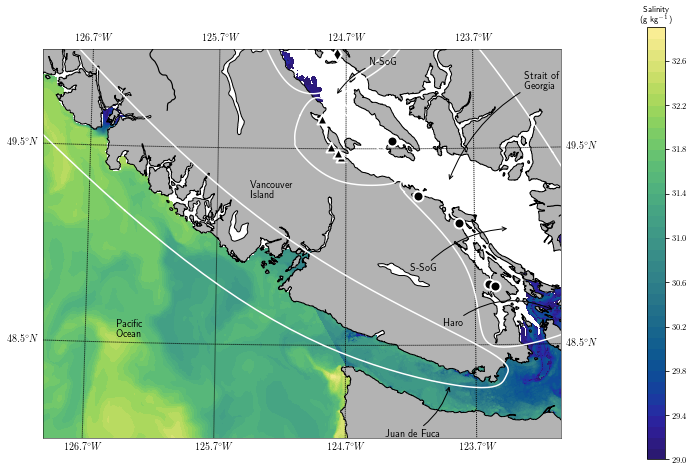

In [17]:
fig=plt.figure(figsize=(12,10))
slat = infil[:,6]
slon = infil[:,7]
ln = infil[:,2]

#model site
modlat = 49.125
modlong = - 123.558

#some masking
mskJ = (ln == 5) #black dots
mskH = (ln == 4) #blue dots
mskS = (ln == 2) #green dots
mskC = (ln == 1.5) #nothing
mskN = (ln == 1) #orange dots

# Define boundaries
latStart = 48 #47.5
latEnd = 50
lonStart = -127
lonEnd = -123

# Define map projection
axm=fig.add_axes([.1,.1,.6,.8])
m = Basemap(ax=axm,llcrnrlon = lonStart, llcrnrlat = latStart, urcrnrlon = lonEnd, 
  urcrnrlat = latEnd, resolution = 'f', projection = 'cass', lon_0=-124.5, 
  lat_0=48.75) #cassini projection (not sure)
m.drawmapboundary(fill_color='white', linewidth=0.5) #boundaries colour

cbax=fig.add_axes([.8,.2,.02,.6])

# Draw bathymetry
#lon, lat = np.meshgrid(lon, lat) # recast lat and lon as meshgrids
xLO, yLO = m(lonLO, latLO) # and convert to x, y coordinates in map projection
xSS, ySS = m(lonSS, latSS) # and convert to x, y coordinates in map projection
levels = np.arange(29,33,.1) # change the different classes here
m0=m.contourf(xLO, yLO, salLO_0, levels, cmap = LevelColormap(levels, cmap = cm1))
m1=m.contourf(xSS, ySS, salSS, levels, cmap = LevelColormap(levels, cmap = cm1))
#levels = [-150] # define the black line to determine the regions
mpl.rcParams['contour.negative_linestyle'] = 'solid' # drawing line of regions
#c = m.contour(x, y, bathy, levels, colors = 'k', linewidth=0.1) # drawing line of regions #black contour lines
#plt.clabel(c, inline=1, fmt='%d', fontsize=7) # label of the altitude of the line of regions #black contour lines
# - 150 shows the two shallow parts at the north end of the southern gulf islands
# - 200 shows the deep trench in Haro (as does - 150)
# - 120 highlights the Victoria sill nicely
cb=fig.colorbar(m0,cax=cbax)
cbax.set_title('Salinity\n(g kg$^{-1}$)')

# define some colours (if you need new colours, see website https://flatuicolors.com/ - numbers should between 1 and 0, so divide by 256)
# colours by default are in yellow '', see python documentation
brgree=(0., 1., 0.)
pureblue=(0., 0., 1.)
#harblue=(0.2, 0., 0.7)
#lpurple=(0.9, 0., 0.9)
harblue=(0.9, 0., 0.9)
orange=(0.9, 0.6, 0.)

# Draw coasts, rivers, continents
m.fillcontinents(color=(0.7, 0.7, 0.7), lake_color='white')
m.drawcoastlines()
#m.drawcountries() # if you want the countries, uncomment here
#m.drawrivers() # same for rivers
m.drawrivers(linewidth=1.2) # change the line depth of rivers

# draw parallels and meridians.
m.drawparallels(np.arange(47.5,51.5,1.), labels=[True,True,True,True])
m.drawmeridians(np.arange(-128.7,-121.7,1.), labels=[True,True,True,True])

# plot station locations
# m.scatter(slon, slat, color='w', s=50, latlon=True, zorder=2)
#m.scatter(slon, slat, color='r', latlon=True)

# m.scatter(slon[mskJ], slat[mskJ], color='k', latlon=True, zorder=2) # only plot if ln = 5
# m.scatter(slon[mskH], slat[mskH], s=30, color= '#CB2CD8', latlon=True, zorder=2)
# m.scatter(slon[mskS], slat[mskS], s=30, color= '#B86D26', latlon=True, zorder=2)
# m.scatter(slon[mskN], slat[mskN], s=30, color= '#459C4A', latlon=True, zorder=2)
m.scatter(slon[mskH], slat[mskH], s=100, color= 'k', marker = 'o', edgecolor = 'white', linewidth = 2, latlon=True, zorder=2)
m.scatter(slon[mskS], slat[mskS], s=100, color= 'k', marker = '^', edgecolor = 'white', linewidth = 2, latlon=True, zorder=2)
m.scatter(slon[mskN], slat[mskN], s=100, color= 'k', marker = 'd', edgecolor = 'white', linewidth = 2, latlon=True, zorder=2)
xi,yi,px,py=getblob('blob1.csv')
m.plot(xi,yi, 'w-', latlon=True, zorder=2)
#m.plot(px,py, 'r*', latlon=True, zorder=2)
xi,yi,px,py=getblob('blob2.csv')
m.plot(xi,yi, 'w-', latlon=True, zorder=2)
#m.plot(px,py, 'r*', latlon=True, zorder=2)
xi,yi,px,py=getblob('blob3.csv')
m.plot(xi,yi, 'w-', latlon=True, zorder=2)
#m.plot(px,py, 'r*', latlon=True, zorder=2)
xi,yi,px,py=getblob('blob4.csv')
m.plot(xi,yi, 'w-', latlon=True, zorder=2)
#m.plot(px,py, 'r*', latlon=True, zorder=2)
#m.scatter(modlong, modlat, color='k', s=30, latlon=True)
#m.scatter(modlong, modlat, color='w', s=20, latlon=True)


# Normal annotations (Name, location, useless) add whatever you want, \n is space
axm.annotate('Vancouver\nIsland', xy=m(-125.45,49.25), xycoords='data')
#plt.annotate('British\nColumbia', xy=m(-122.70,50.20), xycoords='data')
axm.annotate('Fraser R.', xy=m(-122.90,49.105), xycoords='data')
# plt.annotate('River', xy=m(-122.49,49.04), xycoords='data')
#plt.annotate('Juan\nde\n Fuca', xy=m(-124.40,48.06), xycoords='data')
# plt.annotate('Skagit R.', xy=m(-122.25,48.41), xycoords='data')
axm.annotate('Pacific\nOcean', xy=m(-126.465,48.53), xycoords='data')

# Annotations with lines, add here if you want to add a label with an arrow (Name, location of label, useless, location of end arrow, useless, kind of arrow)
axm.annotate('N-SoG', xy=m(-124.78, 49.77), xycoords='data', xytext=m(-124.52, 49.93), textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
axm.annotate('S-SoG', xy=m(-123.43, 49.09), xycoords='data', xytext=m(-124.20, 48.88), textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2'))
axm.annotate('Haro', xy=m(-123.09, 48.67), xycoords='data', xytext=m(-123.95, 48.60), textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3'))
axm.annotate('Juan de Fuca', xy=m(-123.9,48.3), xycoords='data', xytext=m(-124.40, 48.04), textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
#plt.annotate('Fraser River', xy=m(-123.0,49.26), xycoords='data', xytext=m(-122.40, 49.10), textcoords='data', arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0.0'))
# plt.annotate('Puget\nSound', xy=m(-122.45,47.84), xycoords='data', xytext=m(-122.13, 47.9), textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
axm.annotate('Strait of\nGeorgia', xy=m(-123.9,49.33), xycoords='data', xytext=m(-123.30, 49.8), textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
             
# show and save plot
# plt.savefig('StudyAreaMap.pdf')
# plt.savefig('StudyAreaMap.jpeg')

plt.show()
#fig.savefig('StudyAreaMap.png',dpi=150,bbox_inches='tight')

In [18]:
# get rid of 128.7W 
test=nc.Dataset('/results/forcing/LiveOcean/downloaded/20170601/low_passed_UBC.nc')

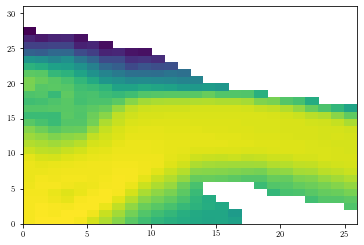

In [19]:
plt.pcolormesh(test.variables['salt'][0,0,:,:])

In [20]:
test.close()

<ipython-input-21-c905cdb4ca40>:1: RuntimeWarning: invalid value encountered in less
  m=plt.pcolormesh(np.ma.masked_where(salLO<30,salLO-salLO_0))


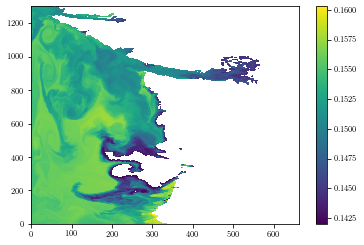

In [21]:
m=plt.pcolormesh(np.ma.masked_where(salLO<30,salLO-salLO_0))
plt.colorbar(m)

In [22]:
np.max(np.abs(salLO-salLO_0)),

(0.1602970156549901,)